In [49]:
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import svm

# link to google drive to obtain and read the datasets
from google.colab import drive
drive.mount('/content/drive/')
path_to_dataset = 'drive/MyDrive/Appunti Università/Magistrale/Machine Learning/Progetto/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Importazione del training set e test set

Leggo e stampo il dataset di training

In [50]:
train_df = pd.read_csv(path_to_dataset + 'modified_train_2023.csv', sep=',')
train_df.head()

,tournament,surface,round,player_1,player_2,player_1_rank,player_2_rank,player_1_bet365,player_2_bet365,player_1_pinnacle,player_2_pinnacle,winner
0,Australian Open,Hard,1st Round,Watanuki Y.,Rinderknech A.,138.0,59.0,2.30,1.62,2.18,1.77,1
1,Australian Open,Hard,1st Round,Etcheverry T.,Barrere G.,79.0,83.0,2.30,1.62,2.43,1.63,1
2,Australian Open,Hard,1st Round,Cerundolo F.,Pella G.,29.0,181.0,1.13,6.00,1.17,6.06,1
3,Australian Open,Hard,1st Round,Hurkacz H.,Martinez P.,11.0,60.0,1.06,10.00,1.06,13.22,1
4,Australian Open,Hard,1st Round,Nishioka Y.,Ymer M.,33.0,69.0,1.91,1.91,2.02,1.88,1


Leggo e stampo il dataset di test

In [51]:
test_df = pd.read_csv(path_to_dataset + 'modified_test_2024.csv', sep=',')
test_df.head()

,tournament,surface,round,player_1,player_2,player_1_rank,player_2_rank,player_1_bet365,player_2_bet365,player_1_pinnacle,player_2_pinnacle,winner
0,Australian Open,Hard,1st Round,Munar J.,Shevchenko A.,82.0,48.0,3.20,1.36,3.06,1.43,1
1,Australian Open,Hard,1st Round,Kotov P.,Rinderknech A.,65.0,94.0,1.62,2.30,1.69,2.30,1
2,Australian Open,Hard,1st Round,Machac T.,Mochizuki S.,75.0,136.0,1.25,4.00,1.30,3.92,1
3,Australian Open,Hard,1st Round,Fritz T.,Diaz Acosta F.,12.0,90.0,1.03,15.00,1.04,17.97,1
4,Australian Open,Hard,1st Round,Halys Q.,Harris L.,110.0,167.0,3.20,1.36,3.59,1.34,1


## Aggiustamenti dei dataset

Prendo tutte le colonne che contengono stringhe (o comunque non numeri) e le elenco all'interno della lista *to_categorical*. Queste colonne verranno mappate in pandas come **categorie** (dtype)

In [52]:
to_categorical = ['tournament', 'surface', 'round', 'player_1', 'player_2']
for category in to_categorical:
  train_df[category] = train_df[category].astype('category')
  test_df[category] = test_df[category].astype('category')

Ora stiamo mappando tutte le categorie con dei numeri. Lo facciamo sia per il dataset di training che di test.

---

Per ottenere una mappatura corretta facciamo in modo che una certa categoria venga mappata nello stesso modo in entrambi i dataset. Ad esempio:

train: "Pippo" -> 1  allora test: "Pippo" -> 1 (in una certa colonna)

---

Le colonne "player_1" e "player_2" contengono i nomi dei giocatori e questi devono essere mappati allo stesso modo in entrambe le colonne.

In [53]:
# create a dictionary to store the mappings for each column
mappings = {}

# convert the training dataset
label_encoder = LabelEncoder()
for col in to_categorical:
  if col != 'player_1' and col != 'player_2':
    train_df[col] = label_encoder.fit_transform(train_df[col])
    mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# convert the test dataset
for col in to_categorical:
  if col != 'player_1' and col != 'player_2':
    test_df[col] = [mappings[col].get(x, -1) for x in test_df[col]]

# convert the player columns in the training dataset
names = pd.concat([train_df['player_1'], train_df['player_2']]).unique()
label_encoder.fit(names)
train_df['player_1'] = label_encoder.transform(train_df['player_1'])
train_df['player_2'] = label_encoder.transform(train_df['player_2'])

# convert the player columns in the test dataset
test_df['player_1'] = label_encoder.transform(test_df['player_1'])
test_df['player_2'] = label_encoder.transform(test_df['player_2'])

## Tuning dei parametri

Effettuo la cross-validation per cercare i migliori parametri per il modello definitivo (tuning)

In [54]:
target_name = 'winner'
feature_names = [col for col in train_df.columns.tolist() if col != target_name]


# X contains feature to train/test (test is for cross-validation)
# Y contains target
X_train, X_test, y_train, y_test = train_test_split(train_df[feature_names], train_df[target_name], test_size=0.3, random_state=42)

Imposto i vari parametri da controllare per il tuning. Insieme ai valori che possono assumere

In [55]:
param_grid = [
    {
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto'] + [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
        'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
    },
    {
        'kernel': ['sigmoid'],
        'gamma': ['scale', 'auto'] + [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
        'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
    },
    {
        'kernel': ['linear'],
        'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
    }
]

Questa sezione permette di fare tuning sui dati e trovare le migliori combinazioni per il *DecisionTreeClassifier*.

Esistono sostanzialmente due modi:
1.   GridSearchCV: Esegue una ricerca esaustiva su una griglia di valori predefiniti per i parametri.
2.   RandomizerSearchCV: Esegue una ricerca casuale su un campione di valori per i parametri

In generale GridSearchCV offre un analisi molto esaustiva (in quanto controlla tutte le possibili combinazioni) ma è molto costoso a livello computazionale. Viceversa il RandomizerSearchCV.

In [56]:
'''
svm = svm.SVC()

search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_grid,
    cv=10, n_iter=1000, n_jobs=-1, verbose=10,
    random_state=42,
    return_train_score=True
)



search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=10, n_jobs=-1, verbose=10,
    return_train_score=True
)

search.fit(X_train, y_train)

print('Best random search parameters: ', search.best_params_)
print('\n\n')
print('Best random search score: ', search.best_score_)
print('\n\n')
print(search.best_estimator_)
'''

"\nsvm = svm.SVC()\n\nsearch = RandomizedSearchCV(\n    estimator=svm,\n    param_distributions=param_grid,\n    cv=10, n_iter=1000, n_jobs=-1, verbose=10,\n    random_state=42,\n    return_train_score=True\n)\n\n\n\nsearch = GridSearchCV(\n    estimator=svm,\n    param_grid=param_grid,\n    cv=10, n_jobs=-1, verbose=10,\n    return_train_score=True\n)\n\nsearch.fit(X_train, y_train)\n\nprint('Best random search parameters: ', search.best_params_)\nprint('\n\n')\nprint('Best random search score: ', search.best_score_)\nprint('\n\n')\nprint(search.best_estimator_)\n"

## Predizioni

Dopo il tuning posso testare l'albero sull'intero dataset per vedere i risultati

In [57]:
model = svm.SVC(
    C=10,
    kernel='linear',
    random_state=42
)
model.fit(train_df[feature_names], train_df[target_name])

SVC(C=10, kernel='linear', random_state=42)

In [58]:
# Valuta il modello utilizzando i dati di test
y_pred = model.predict(test_df[feature_names])

print('Test set - Report\n')
print(classification_report(y_pred, test_df[target_name]))

Test set - Report

              precision    recall  f1-score   support

           1       0.65      0.77      0.70        48
           2       0.79      0.68      0.73        62

    accuracy                           0.72       110
   macro avg       0.72      0.72      0.72       110
weighted avg       0.73      0.72      0.72       110



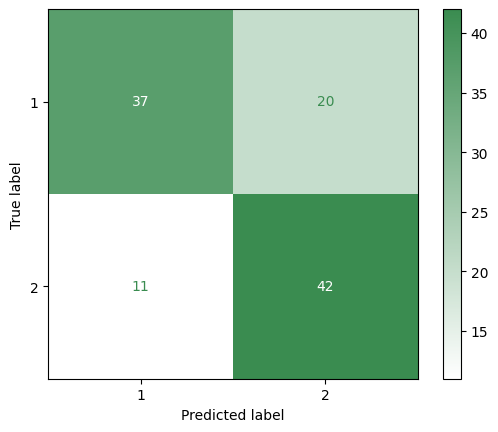

In [59]:
# Color range
white = np.array([255, 255, 255]) / 255
green = np.array([58, 140, 80]) / 255
colors_rgb = np.vstack((white, green))
colors_hex = [colors.rgb2hex(rgb) for rgb in colors_rgb]
cmap = colors.LinearSegmentedColormap.from_list('white_to_green', colors_hex)

# Toggle confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=test_df[target_name], y_pred=y_pred, labels=model.classes_, cmap=cmap)

plt.show()

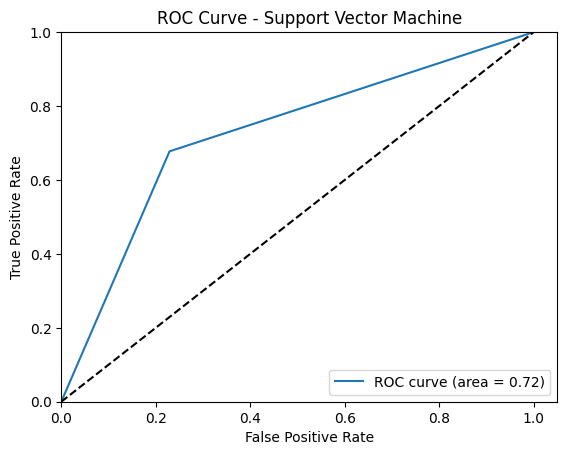

In [60]:
# Compute la curva ROC
positive_class = model.classes_[np.argmax(np.bincount(test_df[target_name]))]
fpr, tpr, thresholds = roc_curve(y_pred, test_df[target_name], pos_label=positive_class)

# Compute AUC
roc_auc = roc_auc_score(y_pred, test_df[target_name])

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machine')
plt.legend(loc="lower right")
plt.show()